### DKU Hackathon 2024
> # Healthcare: Your health on your phone

Machine Learning models to predict disease from blood test measurements


In [69]:
# Necessary library imports

import pandas as pd # csv file management
import matplotlib.pyplot as plt # heat map and other visualisations
import seaborn as sns
import numpy as np # handle numerical values
# Machine learning models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px

In [70]:
# file loading
df = pd.read_csv('csvfile.csv')
# edits for better data representation
df.drop('id', axis = 1, inplace = True)
df.columns = ['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar', 'red_blood_cells', 'pus_cell',
              'pus_cell_clumps', 'bacteria', 'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
              'potassium', 'haemoglobin', 'packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count',
              'hypertension', 'diabetes_mellitus', 'coronary_artery_disease', 'appetite', 'peda_edema',
              'anemia', 'class']
# convert binary type columns into numerical type
df['packed_cell_volume'] = pd.to_numeric(df['packed_cell_volume'], errors='coerce')
df['white_blood_cell_count'] = pd.to_numeric(df['white_blood_cell_count'], errors='coerce')
df['red_blood_cell_count'] = pd.to_numeric(df['red_blood_cell_count'], errors='coerce')
# classifying categorical and numerical columns
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
num_cols = [col for col in df.columns if df[col].dtype != 'object']

In [71]:
# fix mistakes
df['diabetes_mellitus'].replace(to_replace = {'\tno':'no','\tyes':'yes',' yes':'yes'},inplace=True)
df['coronary_artery_disease'] = df['coronary_artery_disease'].replace(to_replace = '\tno', value='no')
df['class'] = df['class'].replace(to_replace = {'ckd\t': 'ckd', 'notckd': 'not ckd'})
df['class'] = df['class'].map({'ckd': 0, 'not ckd': 1})
df['class'] = pd.to_numeric(df['class'], errors='coerce')

<ipython-input-72-61faedc1523b>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True, linewidths = 2, linecolor = 'grey')


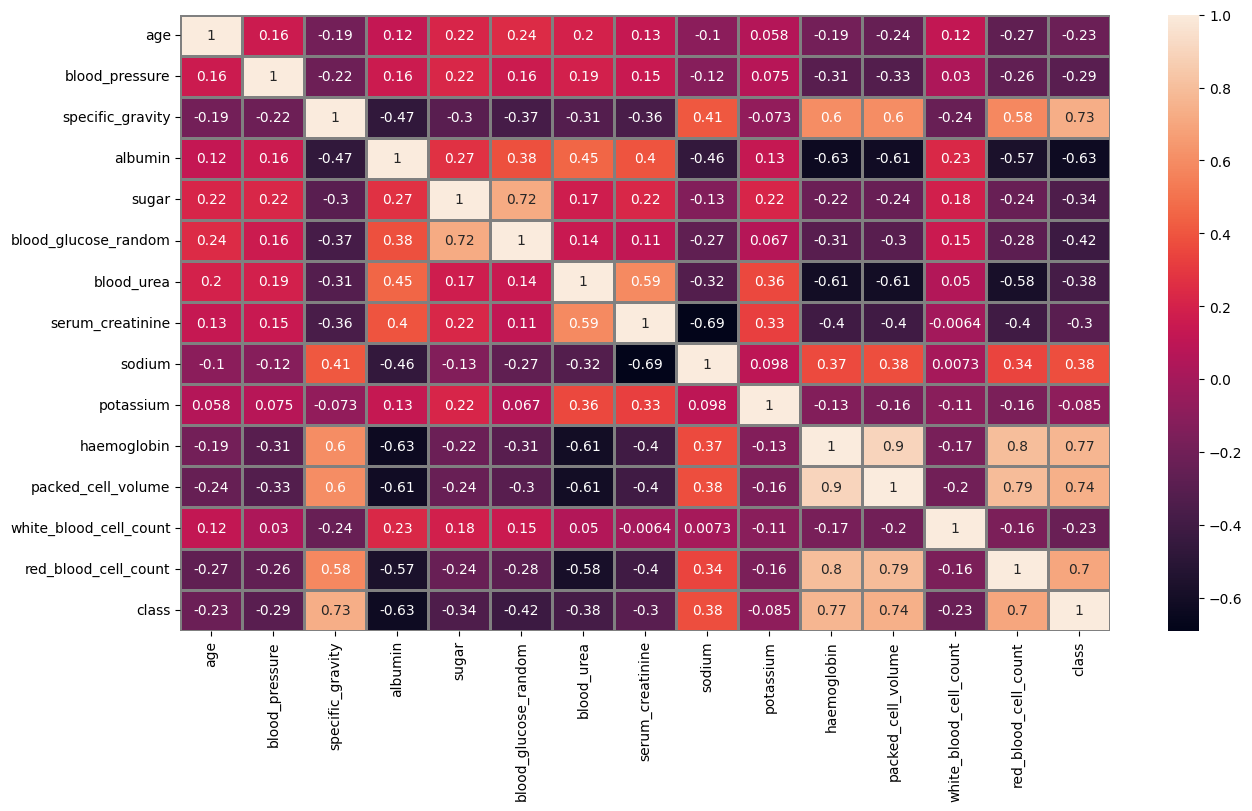

In [72]:
# plotting a heat map
plt.figure(figsize = (15, 8))
sns.heatmap(df.corr(), annot = True, linewidths = 2, linecolor = 'grey')
plt.show()

In [73]:
# fill null values

def random_sampling(feature): # random sampling (higher values)
    random_sample = df[feature].dropna().sample(df[feature].isna().sum())
    random_sample.index = df[df[feature].isnull()].index
    df.loc[df[feature].isnull(), feature] = random_sample

def mean_sampling(feature): # mean sampling (lower values)
    mode = df[feature].mode()[0]
    df[feature] = df[feature].fillna(mode)

# filling num_cols null values using random sampling method

for col in num_cols:
    random_sampling(col)
random_sampling('red_blood_cells')
random_sampling('pus_cell')
for col in cat_cols:
    mean_sampling(col)

In [74]:
le = LabelEncoder() # treat the two categories of cat_cols

for col in cat_cols:
    df[col] = le.fit_transform(df[col])

In [75]:
ind_col = [col for col in df.columns if col != 'class']
dep_col = 'class'

x = df[ind_col]
y = df[dep_col]

# splitting the data into a training set and a test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 0)

In [76]:
# 1/ KNN: K-Nearest Neighbours

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

# Results

knn_acc = accuracy_score(y_test, knn.predict(x_test))

print(f"Training Accuracy: {accuracy_score(y_train, knn.predict(x_train))}")
print(f"Test Accuracy: {knn_acc} \n")

print(f"Confusion Matrix: \n{confusion_matrix(y_test, knn.predict(x_test))}\n")
print(f"Classification Report: \n {classification_report(y_test, knn.predict(x_test))}")

Training Accuracy: 0.8
Test Accuracy: 0.7583333333333333 

Confusion Matrix: 
[[53 19]
 [10 38]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.74      0.79        72
           1       0.67      0.79      0.72        48

    accuracy                           0.76       120
   macro avg       0.75      0.76      0.75       120
weighted avg       0.77      0.76      0.76       120



In [77]:
# 2/ Decision Tree

dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)

# Results

dtc_acc = accuracy_score(y_test, dtc.predict(x_test))

print(f"Training Accuracy: {accuracy_score(y_train, dtc.predict(x_train))}")
print(f"Test Accuracy: {dtc_acc} \n")

print(f"Confusion Matrix: \n{confusion_matrix(y_test, dtc.predict(x_test))}\n")
print(f"Classification Report: \n {classification_report(y_test, dtc.predict(x_test))}")

Training Accuracy: 1.0
Test Accuracy: 0.95 

Confusion Matrix: 
[[70  2]
 [ 4 44]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.97      0.96        72
           1       0.96      0.92      0.94        48

    accuracy                           0.95       120
   macro avg       0.95      0.94      0.95       120
weighted avg       0.95      0.95      0.95       120



In [78]:
# Hyperparameter tuning

grid_param = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 5, 7, 10],
    'splitter' : ['best', 'random'],
    'min_samples_leaf' : [1, 2, 3, 5, 7],
    'min_samples_split' : [1, 2, 3, 5, 7],
    'max_features' : ['auto', 'sqrt', 'log2']
    }

grid_search_dtc = GridSearchCV(dtc, grid_param, cv = 5, n_jobs = -1, verbose = 1)
grid_search_dtc.fit(x_train, y_train)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1200 fits failed out of a total of 6000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1200 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _v

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 5, 7],
                         'min_samples_split': [1, 2, 3, 5, 7],
                         'splitter': ['best', 'random']},
             verbose=1)

In [79]:
# Results

print("Best score: ", grid_search_dtc.best_score_)
print("Best parameters: ", grid_search_dtc.best_params_)
print("Best estimator: ", grid_search_dtc.best_estimator_)

Best score:  0.9892857142857142
Best parameters:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 7, 'splitter': 'best'}
Best estimator:  DecisionTreeClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=7)


In [80]:
be = grid_search_dtc.best_estimator_

# accuracy score, confusion matrix and classification report of decision tree

be_acc = accuracy_score(y_test, dtc.predict(x_test))

print(f"Training Accuracy: {accuracy_score(y_train, dtc.predict(x_train))}")
print(f"Test Accuracy: {be_acc} \n")

print(f"Confusion Matrix: \n{confusion_matrix(y_test, dtc.predict(x_test))}\n")
print(f"Classification Report: \n {classification_report(y_test, dtc.predict(x_test))}")

Training Accuracy: 1.0
Test Accuracy: 0.95 

Confusion Matrix: 
[[70  2]
 [ 4 44]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.97      0.96        72
           1       0.96      0.92      0.94        48

    accuracy                           0.95       120
   macro avg       0.95      0.94      0.95       120
weighted avg       0.95      0.95      0.95       120



In [81]:
# 3/ Random Forest

rd_clf = RandomForestClassifier(criterion = 'entropy', max_depth = 11, max_features = 'auto', min_samples_leaf = 2, min_samples_split = 3, n_estimators = 130)
rd_clf.fit(x_train, y_train)

# Results

rd_clf_acc = accuracy_score(y_test, rd_clf.predict(x_test))

print(f"Training Accuracy: {accuracy_score(y_train, rd_clf.predict(x_train))}")
print(f"Test Accuracy: {rd_clf_acc} \n")

print(f"Confusion Matrix: \n{confusion_matrix(y_test, rd_clf.predict(x_test))}\n")
print(f"Classification Report: \n {classification_report(y_test, rd_clf.predict(x_test))}")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Training Accuracy: 1.0
Test Accuracy: 0.9666666666666667 

Confusion Matrix: 
[[72  0]
 [ 4 44]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.92      0.96        48

    accuracy                           0.97       120
   macro avg       0.97      0.96      0.96       120
weighted avg       0.97      0.97      0.97       120



In [82]:
# Compare the three chosen models

models = pd.DataFrame({
    'Model' : ['KNN', 'Decision Tree', 'Random Forest'],
    'Score' : [knn_acc, dtc_acc, rd_clf_acc]
    })

models.sort_values(by = 'Score', ascending = False)

,Model,Score
2,Random Forest,0.966667
1,Decision Tree,0.950000
0,KNN,0.758333


In [83]:
# Random Forest is the most accurate (98%)